In [ ]:
#-------------------------------读取数据集------------------------------

In [45]:
#导入包，依赖的环境
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

In [46]:
#拿数据
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [47]:
#看训练集特征
train_data.shape

(1460, 81)

In [48]:
#数据集~少的一个就是房价标签
test_data.shape

(1459, 80)

In [49]:
#取前四行，前四后二特征加上售价标签，display
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


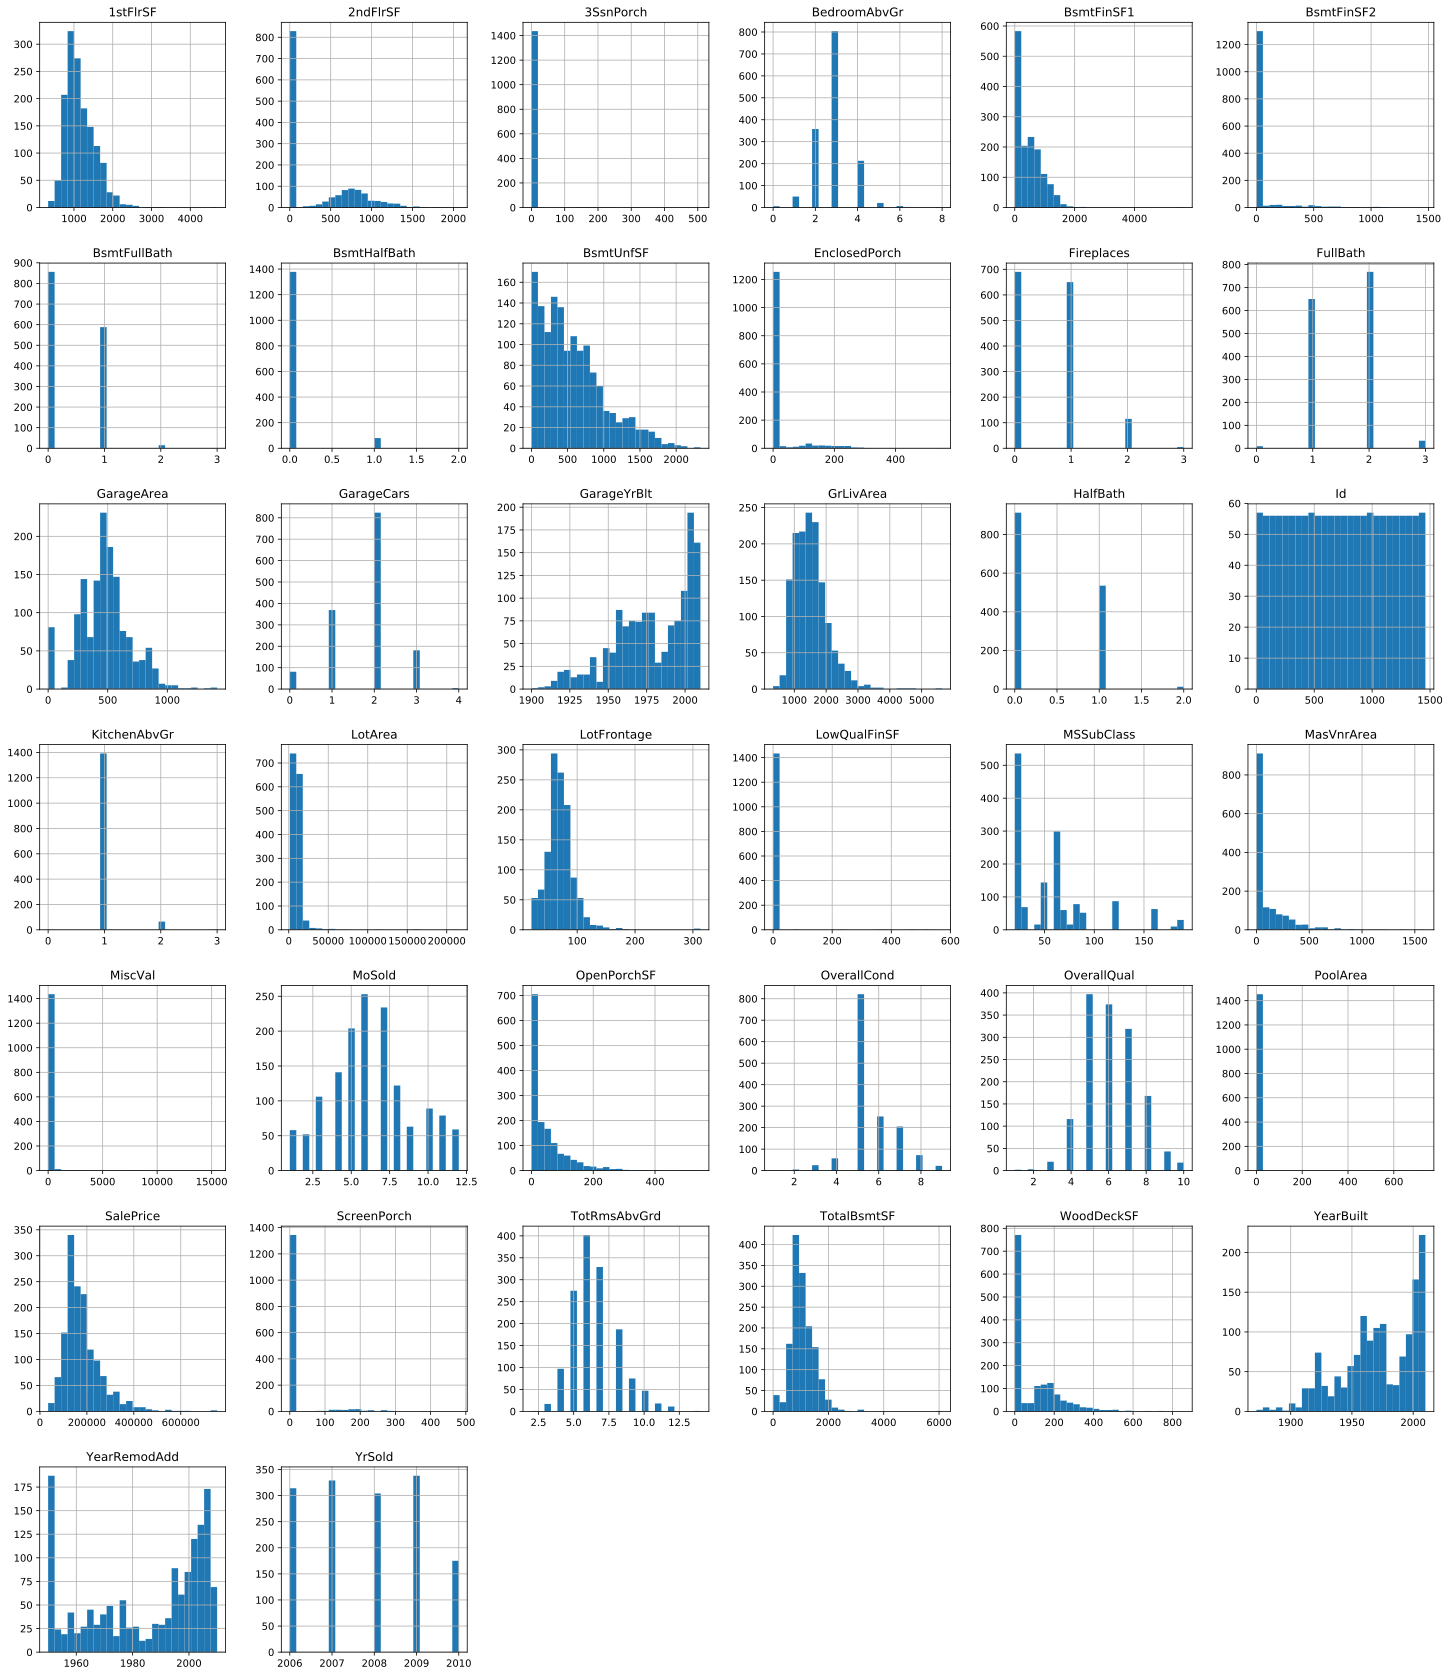

In [52]:
#特征的直方图，找关联
import matplotlib.pyplot as plt
train_data.hist(bins=26, figsize=(25,30))
plt.show()

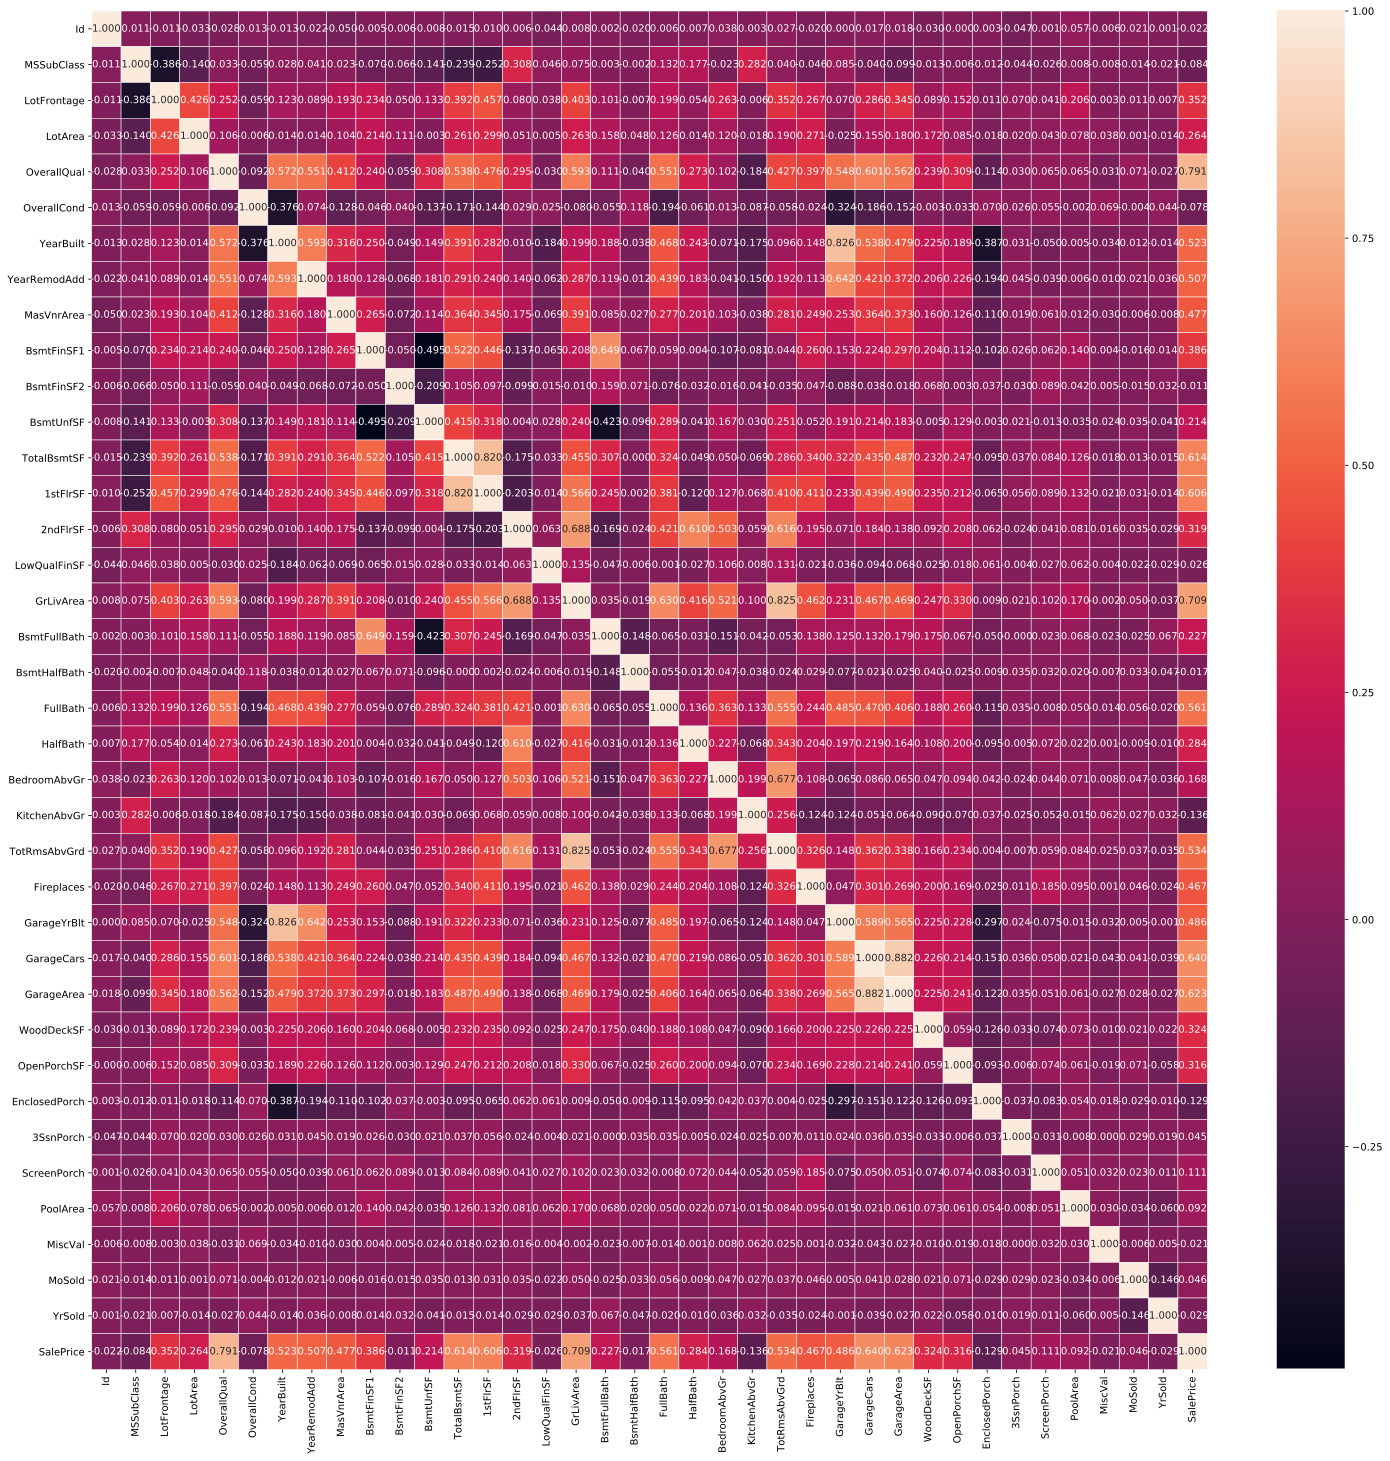

In [53]:
#特征热力图，你猜猜看颜色深表示关联大还是颜色浅
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(train_data.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

In [50]:
#将所有的训练数据和测试数据的79个特征按样本连结。
#？，不使用ID来训练，难以推广到测试集
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
#------------------------------------预处理数据集-----------------------------------

In [54]:
#设该特征在整个数据集上的均值为 μ ，标准差为 σ 。该特征的每个值先减去 μ 再除以 σ 得到标准化后的每个特征值。
#缺失特征值替换成该特征的均值。
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
#--------------------------------------------------------------------------------
#举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，
#那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。
#如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。
#---------------------------------------------------------------------------------
#👇

In [55]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
#AKA保留分类变量中的缺失值，将其单独作为一列
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
#331我不解释了，不知道怎么来的把上面单独注释好好看看

(2919, 331)

In [56]:
#通过values属性得到NumPy格式的数据，并转成NDArray方便后面的训练。
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [65]:
#------------------------------训练模型-------------------------------------

In [57]:
#基本的线性回归模型和平方损失函数来训练模型
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [58]:
#别问Rmse是啥，问就百度，这么点大空间解释不了
def log_rmse(net, features, labels):
    # 将小于1的值设成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [59]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    # 别问，问就是对学习率相对不那么敏感
    #随机梯度下降保持单一的学习率（即 alpha）更新所有的权重，学习率在训练过程中并不会改变；对，就是你天天能看见的SGD
    #Adam 通过计算梯度的一阶矩估计和二阶矩估计而为不同的参数设计独立的自适应性学习率。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [60]:
#K 折交叉验证
#这玩意选择模型设计并调节超参数
#函数返回第i折交叉验证时所需要的训练和验证数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [61]:
#训练 k 次并返回训练和验证的平均误差
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [ ]:
#-----------------------------------模型选择---------------------------------------

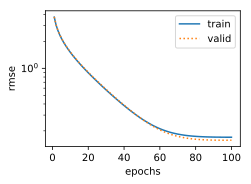

fold 0, train rmse 0.169764, valid rmse 0.157185
fold 1, train rmse 0.162185, valid rmse 0.189614
fold 2, train rmse 0.163556, valid rmse 0.168052
fold 3, train rmse 0.167778, valid rmse 0.154549
fold 4, train rmse 0.162644, valid rmse 0.182778
5-fold validation: avg train rmse 0.165185, avg valid rmse 0.170436


In [62]:
#使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f'
      % (k, train_l, valid_l))
#有时候训练误差可以达到很低，但是在 k 折交叉验证上的误差可能反而较高
#你猜猜看这是过拟合还是欠拟合
#总之，当训练误差降低时，我们要观察 k 折交叉验证上的误差是否也相应降低

In [63]:
#定义预测函数。在预测之前，使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式
#至于所需要的格式是啥，自己看官网https://www.kaggle.com/c/house-prices-advanced-regression-techniques
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

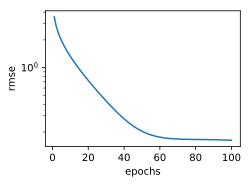

train rmse 0.162559


In [64]:
#设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。
#如果得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，那就结项呗
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)